## Population Demography
### ROH length and estimates of recent N<sub>e</sub>
The below code and method was adapted from [Humble et al. (2023)](http://doi.org/10.1073/pnas.2210756120) to estimate recent trends in N<sub>e</sub> with runs of homozygosity (ROH). The original code from this paper is available [here](https://github.com/ehumble/SHO_roh_load_2022/tree/master).  

 First, we load the relevant packages.  

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


The formula below summarised by Humble et al from [Thompson (2013)](https://doi.org/10.1534/genetics.112.148825) was used to divide ROHs into seven length classes (*L*) corresponding to <2, 2-4, 4-8, 8-16, 16-32, 32-64, and 64-128 generations (*g*) ago:
$$
L = \frac{100}{2 * g}
$$

Essentially, this equation is assuming that a time of depth of *g* should result in double the number of meioses events (*m*). Given that a linkage map was unavailable for their study species, Humble et al assumed a recombination rate of 1 cM/Mb. However, recombination rate is generally higher than this estimate and has been shown to be heterogenous within and between avian lineages and even within and between chromosomes ([Nam et al. (2010)](https://doi.org/10.1186/gb-2010-11-6-r68)). To get an understanding of the broad patterns of N<sub>e</sub>, we estimated N<sub>e</sub> using a mean recombination rate of 2.8 cM/Mb as a middle road of recombination rates observed in [Backström et al. (2010)](http://doi.org/10.1101/gr.101410.109) and [Smeds et al. (2016)](http://doi.org/10.1371/journal.pgen.1006044) and as it was estimated in the chicken (*Gallus gallus*).
$$
L = \frac{100}{2.8(2 * g)}
$$

Using the lengths calculated here, we estimated N<sub>e</sub> for each *g*. Here, *F<sub>ROH, t</sub>* represents average population inbreeding coefficient for the maximum numbers of generations (*t*) in the time periods corresponding for each of the seven size classes above.  
$$
F_{ROH, t} = 1 - (1 - \frac{1}{2 * N_{e}})^t
$$

We then define the function `inb_ne()` to estimate N<sub>e</sub> using the mean *F<sub>ROH</sub>* for each *L*.  
$$
N_{e} = \frac{1}{2 * (1 - f_{ROH})^\frac{1}{L}}
$$

Below we also define a function (`bootstrap_Ne()`) for bootstrapping with replacement for each N<sub>e</sub> estimate.

In [2]:
def inb_ne(mean_froh, class_):
    Ne = 1 / (2 * (1 - ((1 - mean_froh) ** (1 / class_))))
    return Ne

#def bootstrap_Ne(iter, df, frac):
#    sampled_df = (df
#                  .groupby(['Generation Class', 'Population'], group_keys=False)
#                  .apply(lambda x: x.sample(frac=frac, replace=True), include_groups=False)
#                  .groupby(['Generation Class', 'Population'], as_index=False)
#                  .agg(mean_froh = ('fROH', 'mean'))
#                  .assign(Ne = lambda x: inb_ne(x['mean_froh'], x['Generation Class']))
#                  )
#    return sampled_df

def bootstrap_Ne(iter, df, frac):
    # Ensure we have the required columns
    required_cols = ['Generation Class', 'Population', 'fROH']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing required columns. Available: {df.columns.tolist()}")
    
    # Sample within each group and preserve all columns
    sampled_groups = []
    for (gen_class, pop), group in df.groupby(['Generation Class', 'Population']):
        sampled_group = group.sample(frac=frac, replace=True)
        sampled_groups.append(sampled_group)
    
    sampled_df = pd.concat(sampled_groups, ignore_index=True)
    
    # Now aggregate
    result = (sampled_df
              .groupby(['Generation Class', 'Population'], as_index=False)
              .agg(mean_froh = ('fROH', 'mean'))
              .assign(Ne = lambda x: inb_ne(x['mean_froh'], x['Generation Class']))
              )
    
    return result

To estimate N<sub>e</sub> for each of the seven *L* defined above, we us the `ROHs.tsv` file. This time, we convert ROH sizes estimated by ROHAN to megabases (defined as `ROH Size in Mb` in the df below), assign the relevant Generation Class (*g*) for each *L* (defined as `length_class`) and find the *F<sub>ROH</sub>* for each ROH in each individual by dividing `ROH Size in Mb` by the estimated size of autosomal chromosomes for the tara iti and kakī reference genomes (in Mb).

Given the influence relatedness among individuals may have on estimates of contemporary N<sub>e</sub>, we excluded all offspring in kakī parental/offspring trios in our data set. We found did not observe obvious differences in our N<sub>e</sub> estimates from parents only vs the entire dataset.  

In [3]:
roh = pd.read_csv('rohan/ROHs.tsv', delimiter='\t')

excluded_samples = [
    'TI89', 'TI52', 'TI62', 'TI64',
    'TI65', 'TI66', 'TI70', 'TI82',
    'TI83', 'TI86', 'TI87', 'TI90', 
    'TI94', 'TI98', 'TI100', 'TI102' 
    ]

roh = roh[~roh['Sample'].isin(excluded_samples)]

roh['ROH Size in Mb'] = roh['ROH Length'] / 1000000

recomb = roh
recomb['Generation Class'] = np.select(
    [
        recomb['ROH Size in Mb'] >= 17.8571,
        (recomb['ROH Size in Mb'] < 17.8571) & (recomb['ROH Size in Mb'] >= 4.4643),
        (recomb['ROH Size in Mb'] < 4.4643) & (recomb['ROH Size in Mb'] >= 2.2321),
        (recomb['ROH Size in Mb'] < 2.2321) & (recomb['ROH Size in Mb'] >= 1.1161),
        (recomb['ROH Size in Mb'] < 1.1161) & (recomb['ROH Size in Mb'] >= 0.5580),
        (recomb['ROH Size in Mb'] < 0.5580) & (recomb['ROH Size in Mb'] >= 0.2790),
        (recomb['ROH Size in Mb'] < 0.2790) & (recomb['ROH Size in Mb'] >= 0.1395),
    ],
    [2, 4, 8, 16, 32, 64, 128],
    default=np.nan
)

recomb['length_class'] = recomb['Generation Class'].map({
    2: ">17.8571",
    4: "4.4643-17.8571",
    8: "2.2321-4.4643",
    16: "1.1161-2.2321",
    32: "0.5580-1.1161",
    64: "0.2790-0.5580",
    128: "0.1395-0.2790"
})

fairy_recomb = recomb[(recomb['Population']!='KI') & (recomb['Population']!='KI_10x') & (recomb['ROH Size in Mb']>=0.1395)]
kaki_recomb = recomb[(recomb['Population']=='KI') & (recomb['ROH Size in Mb']>=0.1395)]
kaki_recomb = kaki_recomb[kaki_recomb['Sample'].isin(['H01383', 'H01384', 'H01385', 'H01386', 'H01387', 'H01388', 'H01389', 'H01390', 'H01391', 'H01392', 'H01393', 'H01394'])]

fairy = (fairy_recomb
    .groupby(['Sample', 'Population', 'Generation Class', 'length_class'], as_index=False, dropna=False)
    .agg(fROH=('ROH Size in Mb', lambda x: sum((x / 1088.797119))))
    )

kaki = (kaki_recomb
    .groupby(['Sample', 'Population', 'Generation Class', 'length_class'], as_index=False, dropna=False)
    .agg(fROH=('ROH Size in Mb', lambda x: sum((x / 1095.624494))))
    )

fairy.head()

,Sample,Population,Generation Class,length_class,fROH
0,AU01,AU,8.0,2.2321-4.4643,0.002985
1,AU01,AU,16.0,1.1161-2.2321,0.006796
2,AU01,AU,32.0,0.5580-1.1161,0.011205
3,AU01,AU,64.0,0.2790-0.5580,0.021400
4,AU01,AU,128.0,0.1395-0.2790,0.032054


In [4]:
iterations = 100
kiresults = [bootstrap_Ne(i, kaki, 0.5) for i in range(iterations)]
ftresults = [bootstrap_Ne(i, fairy, 0.5) for i in range(iterations)]

kiuncert = (pd.concat(kiresults, keys=range(iterations), names=['iter'])
                .reset_index(level='iter'))

ftuncert = (pd.concat(ftresults, keys=range(iterations), names=['iter'])
                .reset_index(level='iter'))

uncertainty = pd.concat([ftuncert, kiuncert], axis=0, ignore_index=True)

In [5]:
print(uncertainty.groupby(['Generation Class', 'Population'])['Ne'].min())

Generation Class  Population
2.0               NZ               7.306612
4.0               AU             176.288407
                  KI              29.401001
                  NZ               7.563983
8.0               AU             544.352726
                  KI              80.431155
                  NZ              42.018280
16.0              AU             869.902562
                  KI             108.285178
                  NZ             106.498356
32.0              AU            1251.868106
                  KI             155.855491
                  NZ             202.092932
64.0              AU            1572.593636
                  KI             233.896749
                  NZ             389.288554
128.0             AU            2114.162322
                  KI             612.770774
                  NZ            1059.282715
Name: Ne, dtype: float64


In [6]:
def calculate_SE(group):
    std_dev = group['Ne'].std()
    count = group['Ne'].count()
    standard_error = std_dev / np.sqrt(count)
    group['SE'] = standard_error
    group['SD'] = std_dev
    return group

Ne = uncertainty.groupby(['Generation Class', 'Population']).apply(calculate_SE).reset_index(drop=True)
Ne = Ne.groupby(['Generation Class', 'Population', 'SD', 'SE'])['Ne'].mean().reset_index()
Ne.head(n=20)

/tmp/ipykernel_39374/1337689962.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Ne = uncertainty.groupby(['Generation Class', 'Population']).apply(calculate_SE).reset_index(drop=True)


,Generation Class,Population,SD,SE,Ne
0,2.0,NZ,1.858909,0.185891,11.368839
1,4.0,AU,102.249423,10.224942,320.149902
2,4.0,KI,32.731177,3.273118,66.495241
3,4.0,NZ,0.444128,0.044413,8.369997
4,8.0,AU,205.725360,20.572536,871.788731
5,8.0,KI,45.048935,4.504893,135.514171
6,8.0,NZ,1.861772,0.186177,46.931437
7,16.0,AU,237.191717,23.719172,1442.862457
8,16.0,KI,22.253389,2.225339,144.496391
9,16.0,NZ,5.401697,0.540170,117.827704


/tmp/ipykernel_39374/472417158.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2-4', '4-8', '8-16', '16-32', '32-64', '64-128'])
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] n

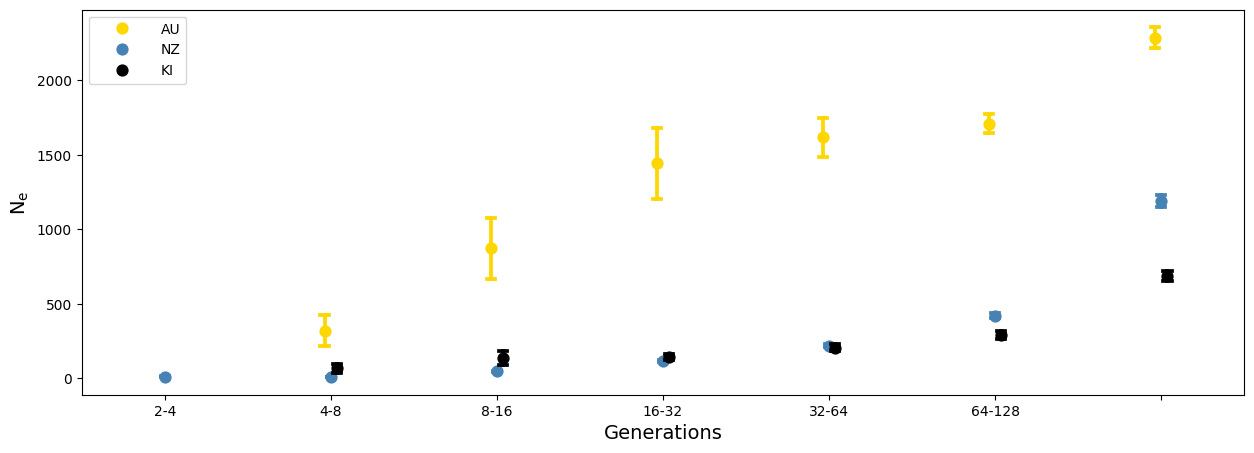

In [7]:
palette = ['gold', 'steelblue', 'black']
order = ['AU', 'NZ', 'KI']
labels = ['AFT', 'TI', 'KĪ']

plt.figure(figsize=(15, 5))
ax = sns.pointplot(data=uncertainty, x='Generation Class', y='Ne', dodge=True, hue='Population', hue_order=order,
                palette=palette, errorbar='sd', capsize=0.05, n_boot=100, estimator='mean', markers='o', linestyles='none')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,
        labels=labels,
        loc='upper left', handlelength=4,
        handler_map={tuple: HandlerTuple(ndivide=None)})

params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
ax.set_title('', loc='left', fontsize=20)
ax.set_xticklabels(['2-4', '4-8', '8-16', '16-32', '32-64', '64-128'])
ax.set_xlabel('Generations', fontsize=14)
ax.set_ylabel('$N_{e}$', fontsize=14)

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/ROH_Recomb_Ne_esimtates.png', dpi=300, bbox_inches='tight')

<Axes: xlabel='Generation Class', ylabel='Ne'>

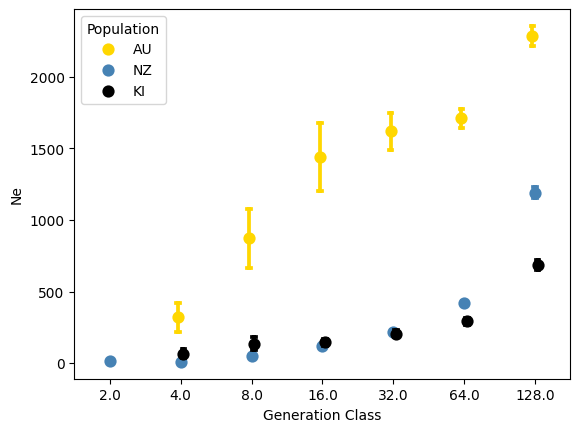

In [8]:
# Add error bars separately if needed
sns.pointplot(data=uncertainty, x='Generation Class', y='Ne', 
              hue='Population', hue_order=order, palette=palette,
              errorbar='sd', capsize=0.05, n_boot=100, estimator='mean',
              markers='o', linestyles='none', dodge=True)

/tmp/ipykernel_39374/331135871.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2-4', '4-8', '8-16', '16-32', '32-64'])


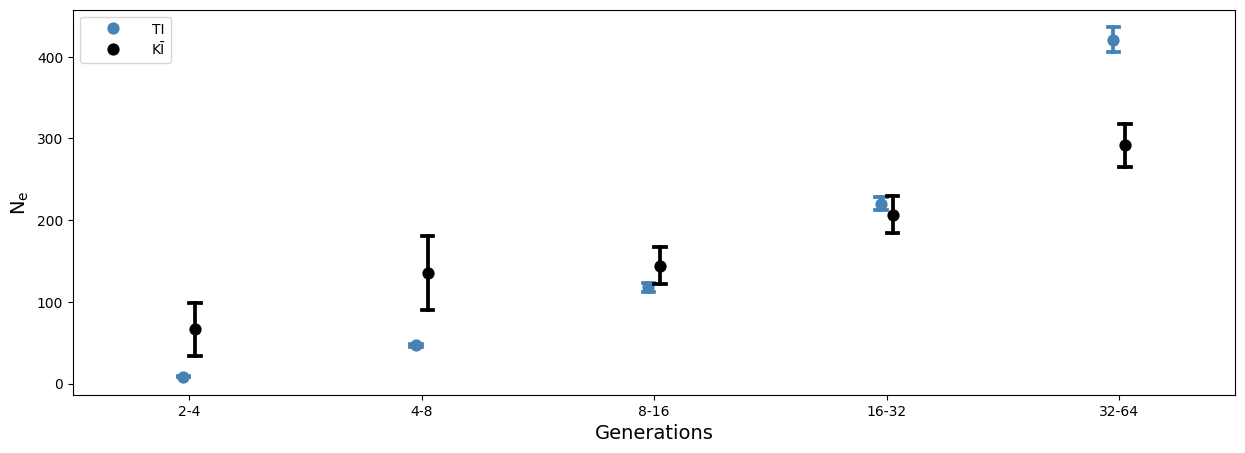

In [10]:
palette = ['steelblue', 'black']

uncertainty_subplot = uncertainty[(uncertainty['Generation Class']>2) & (uncertainty['Generation Class']<128) & (uncertainty['Population']!='AU')]

plt.figure(figsize=(15, 5))
ax = sns.pointplot(data=uncertainty_subplot, x='Generation Class', y='Ne', dodge=True, hue='Population', hue_order=['NZ', 'KI'],
                palette=palette, errorbar='sd', capsize=0.05, n_boot=100, estimator='mean', markers='o', linestyles='none')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,
        labels=['TI', 'KĪ'],
        loc='upper left', handlelength=4,
        handler_map={tuple: HandlerTuple(ndivide=None)})

params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
ax.set_title('', loc='left', fontsize=20)
ax.set_xticklabels(['2-4', '4-8', '8-16', '16-32', '32-64'])
ax.set_xlabel('Generations', fontsize=14)
ax.set_ylabel('$N_{e}$', fontsize=14)

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/ROH_Recomb_Ne_Subset_esimtates.png', dpi=300, bbox_inches='tight')

In [11]:
gen2 = 17857100
gen4 = 4464300
gen8 = 2232100
gen16 = 1116100
large_roh = roh[(roh['ROH Length']>=gen4) & (roh['ROH Length']< gen2)]
large_roh = large_roh.groupby('Sample')['Population'].value_counts().reset_index()
large_roh = large_roh.groupby('Population')['count'].mean().reset_index()

huge_roh = roh[roh['ROH Length']>=gen2]
huge_roh = huge_roh.groupby('Sample')['Population'].value_counts().reset_index()
huge_roh = huge_roh.groupby('Population')['count'].mean().reset_index()

print(huge_roh)

  Population     count
0         NZ  3.771429


In [14]:
roh[roh['ROH Length']>=gen2].groupby(['Sample','Population'])['Population'].count()

Sample  Population
SND04   NZ            1
SND11   NZ            3
SP02    NZ            8
SP03    NZ            3
TI101   NZ            1
TI35    NZ            3
TI36    NZ            3
TI37    NZ            3
TI38    NZ            1
TI40    NZ            1
TI41    NZ            4
TI50    NZ            3
TI51    NZ            8
TI54    NZ            2
TI56    NZ            2
TI57    NZ            5
TI63    NZ            3
TI67    NZ            4
TI68    NZ            2
TI69    NZ            2
TI71    NZ            3
TI72    NZ            7
TI75    NZ            4
TI77    NZ            4
TI81    NZ            5
TI84    NZ            1
TI85    NZ            4
TI88    NZ            1
TI91    NZ            5
TI92    NZ            7
TI93    NZ            5
TI95    NZ            5
TI96    NZ            8
TI97    NZ            6
TI99    NZ            5
Name: Population, dtype: int64

### StairwayPlot2
Below script was modified from [here](https://github.com/xiaoming-liu/stairway-plot-v2/issues/2).

In [ ]:
au_stairway = pd.read_csv('stairwayplot2/AU_neutral_temp/Australian fairy tern (neutral).final.summary', delimiter='\t')
ti_stairway = pd.read_csv('stairwayplot2/TI_neutral_temp/Tara iti (neutral).final.summary', delimiter='\t')
ki_stairway = pd.read_csv('stairwayplot2/KI_neutral_temp/Kakī (neutral).final.summary', delimiter='\t')

fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True, sharey=False)
axs[0].step(au_stairway['year'], au_stairway['Ne_median'], where='post', color = 'gold', linewidth=1, label='Australia')
axs[0].step(au_stairway['year'], au_stairway['Ne_2.5%'], where='post', color = 'gold', linewidth=1, linestyle='dashed')
axs[0].step(au_stairway['year'], au_stairway['Ne_97.5%'], where='post', color = 'gold', linewidth=1, linestyle='dashed')
axs[0].set_title('A)', fontsize=20, loc='left')
axs[0].set_ylim(0, 100000)

axs[1].step(ti_stairway['year'], ti_stairway['Ne_median'], where='post', color = 'steelblue', linewidth=1, label='Tara iti')
axs[1].step(ti_stairway['year'], ti_stairway['Ne_2.5%'], where='post', color = 'steelblue', linewidth=1, linestyle='dashed')
axs[1].step(ti_stairway['year'], ti_stairway['Ne_97.5%'], where='post', color = 'steelblue', linewidth=1, linestyle='dashed')
axs[1].set_title('B)', fontsize=20, loc='left')
axs[1].set_ylim(0, 12500)

axs[2].step(ki_stairway['year'], ki_stairway['Ne_median'], where='post', color = 'black', linewidth=1, label='Kakī')
axs[2].step(ki_stairway['year'], ki_stairway['Ne_2.5%'], where='post', color = 'black', linewidth=1, linestyle='dashed')
axs[2].step(ki_stairway['year'], ki_stairway['Ne_97.5%'], where='post', color = 'black', linewidth=1, linestyle='dashed')
axs[2].set_title('C)', fontsize=20, loc='left')
axs[2].set_ylim(0, 25000)

plt.xlim(0, 800)

plt.xlabel('Years Before Present', fontsize=14)
plt.ylabel('Effective Population Size', fontsize=14)
#plt.xticks(x_ticks, x_labels, fontsize=10)
#plt.yticks(y_ticks, y_labels, fontsize=10)

plt.savefig('plots/fairy_Ne_plot2.png', dpi=300, bbox_inches='tight')

In [ ]:
au_stairway.tail()

In [ ]:
au_hgone = pd.read_csv('GONE/Haldane_Correction/AU_neutral_run1_test/Output_Ne_AU_neutral_test', sep='\t')
ki_hgone = pd.read_csv('GONE/Haldane_Correction/KI_neutral_run1/Output_Ne_KI_neutral', sep='\t')
ti_hgone = pd.read_csv('GONE/Haldane_Correction/TI_neutral_run1_test/Output_Ne_TI_neutral_test', sep='\t')

au_kgone = pd.read_csv('GONE/Kosambi_Correction/AU_neutral_run1/Output_Ne_AU_neutral_test', sep='\t')
ki_kgone = pd.read_csv('GONE/Kosambi_Correction/KI_neutral_run1/Output_Ne_KI_neutral', sep='\t')
ti_kgone = pd.read_csv('GONE/Kosambi_Correction/TI_neutral_run1/Output_Ne_TI_neutral_test', sep='\t')

ki_h_parents = pd.read_csv('GONE/Haldane_Correction/KI_neutral_parents/Output_Ne_KI_parents_neutral', sep='\t')

# Filter to within the last 100 generations as this is the noly period the method is confident in
au_hgone = au_hgone[au_hgone['Generation']<=100]
ki_hgone = ki_hgone[ki_hgone['Generation']<=100]
ti_hgone = ti_hgone[ti_hgone['Generation']<=100]

au_kgone = au_kgone[au_kgone['Generation']<=100]
ki_kgone = ki_kgone[ki_kgone['Generation']<=100]
ti_kgone = ti_kgone[ti_kgone['Generation']<=100]

ki_h_parents = ki_h_parents[ki_h_parents['Generation']<=100]
ki_h_parents['Year'] = ki_h_parents['Generation'] * 6

au_hgone['Population'] = 'AU'
ki_hgone['Population'] = 'KI'
ti_hgone['Population'] = 'TI'

au_hgone['Year'] = au_hgone['Generation'] * 6
ki_hgone['Year'] = ki_hgone['Generation'] * 6
ti_hgone['Year'] = ti_hgone['Generation'] * 6

au_kgone['Population'] = 'AU'
ki_kgone['Population'] = 'KI'
ti_kgone['Population'] = 'TI'

ki_h_parents['Population'] = 'KI'

au_hgone.head()

In [ ]:
sns.lineplot(ti_hgone, x='Year', y='Geometric_mean')
sns.lineplot(ki_hgone, x='Year', y='Geometric_mean')
sns.lineplot(ki_h_parents, x='Year', y='Geometric_mean', color='black')

In [ ]:
sns.lineplot(ti_hgone[ti_hgone['Generation']>10], x='Year', y='Geometric_mean')
sns.lineplot(ki_hgone[ki_hgone['Generation']>10], x='Year', y='Geometric_mean')
sns.lineplot(ki_h_parents[ki_h_parents['Generation']>10], x='Year', y='Geometric_mean', color='black')

In [ ]:
sns.lineplot(au_hgone[au_hgone['Generation']>10], x='Year', y='Geometric_mean', color='gold')

## Artificailly constructing a GENEPOP file